## Description
---
This notebook is for the comparison of HYCOM and *in situ* ACT mooring array sections. For the ACT experiment period, only a gridded velocity section is available. A gridded section of velocity, temperature and salinity is available for the ASCA experiment duration and their means might make a useful comparison against the model runs here.

- The ACT data can be accessed here:
https://beal-agulhas.earth.miami.edu/data-and-products/index.html
Specifically, the ACT *in situ* velocity section data is used:
https://drive.google.com/file/d/112LWQ2Mvtmz-1xFNuySS3kHdmFCHqCAz/view?usp=sharing
- Positive cross-track velocities point approximately toward the northeast (64 deg), and  negative velocities point toward the southwest (244 deg).

If this data is used in a publication, a requested reference as per the website is to be used:
*'Gridded cross-sectional velocities are based on in situ current meter measurements from the Agulhas Current Time-series (ACT) experiment (Beal et al., 2015) and can be downloaded at https://beal-agulhas.rsmas.miami.edu/data-and-products/index.html.'*

- For the HYCOM data, a the m2section routine was used with the following coordinates for the section, as per the sections.in file:

`ACT_ARRAY
28.90  -35.70
27.49 -33.29`
- From the HYCOM NERSC manual:
'*The positive directions of a section can be found by the following rule. When
standing at the first point of a section, and looking towards the next point of the section, then the positive
direction is towards your right-hand side.*'

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

## Import data

In [2]:
ACT = xr.open_dataset('../Data/ACT_array/Section/ACT_2010-2013_full_gridded_ts_extended.nc')
ACT = ACT.sel(time=slice('2010-04-17', '2012-04-11'))
FREE = xr.open_dataset('../Data/ACT_array/Section/FREE_section.nc')
CCI = xr.open_dataset('../Data/ACT_array/Section/CCI_section.nc')
OSTIA = xr.open_dataset('../Data/ACT_array/Section/OSTIA_section.nc')

## Rotate HYCOM velocities
---
Here we need to rotate HYCOM velocities to the normal in order to match the format that the ACT data is in. This could be done by first getting the vector and magnitude and then decomposing into components or it could be done by vector rotation. I will first attempt the second option as I have already tried to do this for the HYCOM m2section routine in Fortran. I recall it working fairly well. I can try make a test example here.

---

Firstly, the angle between starting and ending points needs to be determined. This can be done given starting and ending coordinates of the HYCOM section.in file and the method proposed in this StackOverflow answer:
https://stackoverflow.com/a/72602196

Secondly, the process of rotating the vectors is as described here:
https://www.mathworks.com/help/phased/ref/rotz.html

### Finding angle at which the ACT array is running

In [4]:
start_lon = 28.90
start_lat = -35.70
end_lon = 27.49
end_lat = -33.29

def get_angle(x1,y1,x2,y2):
    return np.arctan2(y2-y1, x2-x1)

gamma = get_angle(start_lon, start_lat, end_lon, end_lat)
print(gamma)

2.100159766515619


### Creating the rotation matrix

In [4]:
gamma = np.radians(45)

def get_RotationMatrix(gamma):
    c, s = np.cos(gamma), np.sin(gamma)
    return np.array(((c, -s), (s, c)))

R = get_RotationMatrix(gamma)
print(R)
R.shape

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


(2, 2)

In [10]:
# [-2,1] @ R
np.dot([-2,1],R)

array([-0.70710678,  2.12132034])

### Rotating the velocity vectors in HYCOM

In [ ]:
[model_u, model_v] @ RotationMatrix


In [14]:
new_matrix = np.array([FREE['east_utot'], FREE['north_vtot']])

# new_matrix2 = xr.concat([FREE['east_utot'], FREE['north_vtot']],dim = 'time')

# newer_matrix = new_matrix.reshape(2,566280)

# new_matrix[0] @ R
new_matrix[:,0,0,0] @ R
# new_matrix.shape

array([-1.82290138, -0.04625542])

In [30]:
new_matrix = np.array([FREE['east_utot'], FREE['north_vtot']])
# new_matrix = zip(FREE['east_utot'], FREE['north_vtot'])
# new_matrix.shape
print(new_matrix)

In [24]:
# new_matrix[:,0,0,0].shape
for x in np.nditer(new_matrix[:,0,:4,0]):
    print(x, end=' ')

0.9604604 0.96545607 0.9673421 0.96823055 -1.5500402 -1.530573 -1.5205152 -1.5130074 

In [94]:
new_matrix[:,0,0,0]

array([ 0.9604604, -1.5500402], dtype=float32)

In [53]:
new_matrix @ R

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 26)

In [10]:
FREE['north_vtot']

<xarray.DataArray 'north_vtot' (time: 726, depth: 30, distance: 26)>
[566280 values with dtype=float32]
Coordinates:
  * time      (time) float32 2.01e+03 2.01e+03 2.01e+03 ... 2.012e+03 2.012e+03
  * distance  (distance) float32 7.071e+03 1.756e+04 ... 2.795e+05 2.898e+05
    depth     (distance) float32 ...

In [6]:
FREE['east_utot']

<xarray.DataArray 'east_utot' (time: 726, depth: 30, distance: 26)>
[566280 values with dtype=float32]
Coordinates:
  * time      (time) float32 2.01e+03 2.01e+03 2.01e+03 ... 2.012e+03 2.012e+03
  * distance  (distance) float32 7.071e+03 1.756e+04 ... 2.795e+05 2.898e+05
    depth     (distance) float32 ...

## Plot velocity

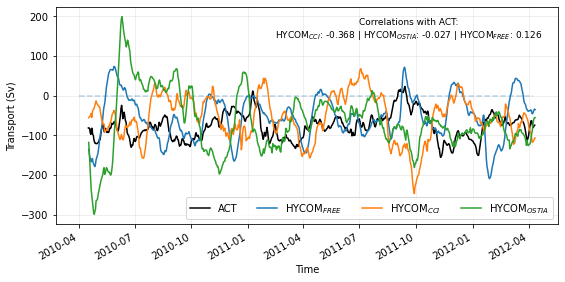

In [6]:
# # calculating correlations
corr_cciact = round(np.corrcoef(CCI.transport[:,0],ACT)[0,1],3)
corr_ostiaact = round(np.corrcoef(OSTIA.transport[:,0],ACT)[0,1],3)
corr_freeact = round(np.corrcoef(FREE.transport[:,0],ACT)[0,1],3)
textbox = 'Correlations with ACT:\nHYCOM$_{CCI}$: ' + '{0}'.format(corr_cciact) +  ' | HYCOM$_{OSTIA}$: ' + '{0}'.format(corr_ostiaact) +  ' | HYCOM$_{FREE}$: ' + '{0}'.format(corr_freeact)

fig = plt.figure(figsize=(9,4))
plt.hlines(0,xmin=pd.to_datetime('2010-04-01'), xmax=pd.to_datetime('2012-04-08'), linestyle='dashed', alpha=0.3)
# plt.vlines(pd.to_datetime('2011-09-28'),ymin=-90, ymax=250, color='red', linestyle='dotted', linewidth=2, alpha=0.85)
# plt.vlines(pd.to_datetime('2011-07-03'),ymin=-90, ymax=250, color='green', linestyle='dotted', linewidth=2, alpha=0.85)
ACT.plot(label='ACT', color='k')
FREE.transport.plot(label='HYCOM$_{FREE}$')
CCI.transport.plot(label='HYCOM$_{CCI}$')
OSTIA.transport.plot(label='HYCOM$_{OSTIA}$')
plt.grid(alpha=0.25)
plt.ylabel('Transport (Sv)')
plt.xlabel('Time')
# fig.text(0.72, 0.88, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center',transform=fig.transFigure, bbox = dict(boxstyle='round', facecolor='white'))
fig.text(0.67, 0.8, textbox, fontsize=9, verticalalignment='center', horizontalalignment='center', transform=fig.transFigure)
plt.legend(ncol=4, loc='lower right')
# plt.savefig('../Figures/act/Trans_tbox_new.png', dpi=300, bbox_inches='tight', format='png')

## Plot temperature, salinity, density

In [48]:
def plot_TempSection(datasets):
    '''Plot vertical sections of HYCOM along ACT transect.
    
    This function will plot 3 plots. First, temperature sections for each dataset.
    Secondly, salinity and lastly, density.
    
    e.g. usage: plot_TempSection(datasets)
    '''
    # Temperature
    fig, axs = plt.subplots(3,1, figsize = (3,5), constrained_layout=True)
    for i,ax in enumerate(axs):
#         ax.plot(datasets[i]['temp'].mean())
        ax.pcolormesh(datasets[i][0]['temp'].mean(dim='time', skipna=True))
        ax.invert_yaxis()
        ax.invert_xaxis()


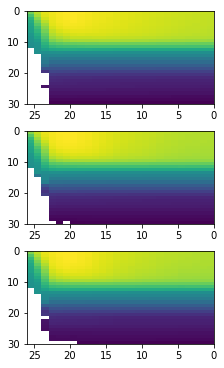

In [49]:
plot_TempSection([(FREE, 'FREE'), (OSTIA, 'OSTIA'), (CCI, 'CCI')])

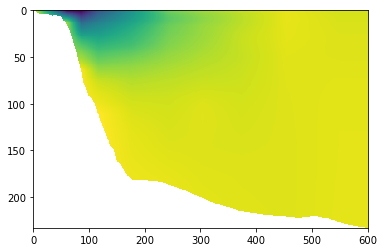

In [54]:
# FREE['temp'].mean(dim='time').plot()
# FREE['temp'].mean(dim='time').transpose()
# plt.pcolormesh(FREE['distance'], FREE['depth'], FREE['temp'].mean(dim='time').transpose())
FREE['depth'] = -FREE['depth']
plt.pcolormesh(ACT['v'].mean(dim='time').transpose())
# plt.contour(FREE['temp'].mean(dim='time'))
ax = plt.gca()
ax.invert_yaxis()
# ax.invert_xaxis()
# plt.pcolormesh(FREE['temp'].mean(dim='time').transpose())
# FREE['distance'].shape

In [50]:
ACT

<xarray.Dataset>
Dimensions:   (depth: 233, distance: 601, time: 1451)
Coordinates:
  * depth     (depth) float64 0.0 20.0 40.0 60.0 ... 4.6e+03 4.62e+03 4.64e+03
  * distance  (distance) float64 0.0 500.0 1e+03 ... 2.99e+05 2.995e+05 3e+05
  * time      (time) datetime64[ns] 2010-04-17T12:00:00 ... 2012-04-11T12:00:00
Data variables:
    v         (time, distance, depth) float64 ...
Attributes: (12/15)
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    title:                  ACT array cross track velocity
    Conventions:            CF-1.6, ACDD-1.3
    processing_level:       Current meter and CPIES velocity data were linear...
    acknowledgement:        The Agulhas Current Time-series experiment is fun...
    references:             Beal L. M., S. Elipot, A. Houk and G. M. Leber, (...
    ...                     ...
    institution:            University of Miami
    project:                Agulhas Current Time-series experiment (ACT)
    time_coverage_start:    2010-04-17T12:00:00Z
    time_coverage_end:      2013-02-19T00:00:00Z
    product version:        1.0
    sea name:               Indian Ocean

AttributeError: 'DataArray' object has no attribute 'contour'

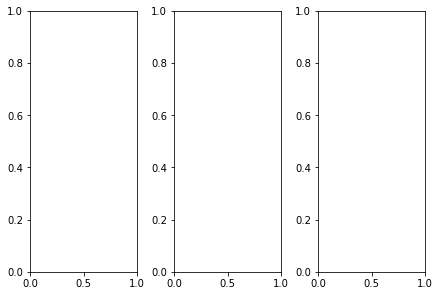

In [32]:
plot_TempSection([FREE,OSTIA,CCI])

In [54]:
FREE['temp'].mean(dim='time').plot()
# FREE['temp'].swap_dims({'depth': 'distance'})

ValueError: ('distance', 'distance') must be a permuted list of ('depth', 'distance'), unless `...` is included

In [44]:
FREE

<xarray.Dataset>
Dimensions:     (time: 726, distance: 26, depth: 30)
Coordinates:
  * time        (time) float32 2.01e+03 2.01e+03 ... 2.012e+03 2.012e+03
  * distance    (distance) float32 7.071e+03 1.756e+04 ... 2.795e+05 2.898e+05
    depth       (distance) float32 4.522e+03 4.507e+03 4.481e+03 ... 98.99 72.61
Data variables:
    lon         (distance) float32 28.92 28.91 28.77 28.75 ... 27.64 27.62 27.61
    lat         (distance) float32 -35.64 -35.54 -35.46 ... -33.51 -33.42 -33.32
    intf_lower  (time, depth, distance) float32 ...
    saln        (time, depth, distance) float32 ...
    temp        (time, depth, distance) float32 25.04 25.03 25.05 ... nan nan
    pres        (time, depth, distance) float32 ...
    east_utot   (time, depth, distance) float32 ...
    north_vtot  (time, depth, distance) float32 ...
Attributes:
    sectionname:  ACT_ARRAY

In [19]:
ACT = xr.open_dataset('../Data/ACT_array/Transport/ACTtransport_insitu.nc')
ACT

<xarray.Dataset>
Dimensions:  (time: 2078)
Coordinates:
  * time     (time) datetime64[ns] 2010-04-17T12:00:00 2010-04-18 ... 2013-02-19
Data variables:
    Tbox     (time) float32 ...
    Tjet     (time) float32 ...
Attributes: (12/17)
    featureType:          timeSeries
    title:                Agulhas Current boundary and jet transports from in...
    summary:              see methodology in Beal L. M., S. Elipot, A. Houk a...
    history:              original and first version
    acknowledgement:      The Agulhas Current Time-series experiment is funde...
    references:           Beal L. M., S. Elipot, A. Houk and G. M. Leber, (20...
    ...                   ...
    publisher_name:       Shane Elipot
    publisher_email:      selipot@rsmas.miami.edu
    time_coverage_start:  2010-04-17T12:00:00Z
    time_coverage_end:    2010-04-17T12:00:00Z
    product version:      1.0
    sea name:             Indian Ocean

In [37]:
cci

<xarray.Dataset>
Dimensions:           (N_2: 2, section: 1, time: 723)
Coordinates:
  * time              (time) datetime64[ns] 2010-04-17T12:00:00 ... 2012-04-08T12:00:00
Dimensions without coordinates: N_2, section
Data variables:
    sectionname       (section) |S20 ...
    section_lon       (section, N_2) float32 ...
    section_lat       (section, N_2) float32 ...
    transport         (time, section) float32 ...
    transport_neg     (time, section) float32 ...
    transport_pos     (time, section) float32 ...
    icetransport      (time, section) float32 ...
    icetransport_neg  (time, section) float32 ...
    icetransport_pos  (time, section) float32 ...
Attributes:
    title:        TOPAZ transport across sections
    institution:  NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    references:   http://topaz.nersc.no
    comment:      Transports are defined as positive if it is towards the rig...

In [7]:
HYCOMcci.where(HYCOMcci.transport==HYCOMcci.transport.max(), drop=True).squeeze()

<xarray.Dataset>
Dimensions:           (N_2: 2)
Coordinates:
    time              datetime64[ns] 2011-09-28T12:00:00
Dimensions without coordinates: N_2
Data variables:
    sectionname       object b'ACT_ARRAY           '
    section_lon       (N_2) float32 27.76488 28.905796
    section_lat       (N_2) float32 -33.59943 -35.54219
    transport         float32 238.82446
    transport_neg     float32 -0.9523389
    transport_pos     float32 239.7768
    icetransport      float32 0.0
    icetransport_neg  float32 0.0
    icetransport_pos  float32 0.0
Attributes:
    title:        TOPAZ transport across sections
    institution:  NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    references:   http://topaz.nersc.no
    comment:      Transports are defined as positive if it is towards the rig...

In [8]:
HYCOMcci.where(HYCOMcci.transport==HYCOMcci.transport.min(), drop=True).squeeze()

<xarray.Dataset>
Dimensions:           (N_2: 2)
Coordinates:
    time              datetime64[ns] 2011-07-03T12:00:00
Dimensions without coordinates: N_2
Data variables:
    sectionname       object b'ACT_ARRAY           '
    section_lon       (N_2) float32 27.76488 28.905796
    section_lat       (N_2) float32 -33.59943 -35.54219
    transport         float32 -67.48152
    transport_neg     float32 -109.96445
    transport_pos     float32 42.482925
    icetransport      float32 0.0
    icetransport_neg  float32 0.0
    icetransport_pos  float32 0.0
Attributes:
    title:        TOPAZ transport across sections
    institution:  NERSC, Thormoehlens gate 47, N-5006 Bergen, Norway
    references:   http://topaz.nersc.no
    comment:      Transports are defined as positive if it is towards the rig...

In [ ]:
# read SST datasets
